<a href="https://colab.research.google.com/github/mahenoor22/skin-disease-build/blob/main/model_build/HAM28_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL as pil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import seaborn as sns

!chmod 600 /content/kaggle.json

# **Visualising Dataset**

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content'
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip \*.zip && rm *.zip
meta=pd.read_csv('/content/HAM10000_metadata.csv')
meta.info()

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_part_2/ISIC_0029342.jpg  
  inflating: ham10000_images_part_2/ISIC_0029343.jpg  
  inflating: ham10000_images_part_2/ISIC_0029344.jpg  
  inflating: ham10000_images_part_2/ISIC_0029345.jpg  
  inflating: ham10000_images_part_2/ISIC_0029346.jpg  
  inflating: ham10000_images_part_2/ISIC_0029347.jpg  
  inflating: ham10000_images_part_2/ISIC_0029348.jpg  
  inflating: ham10000_images_part_2/ISIC_0029349.jpg  
  inflating: ham10000_images_part_2/ISIC_0029350.jpg  
  inflating: ham10000_images_part_2/ISIC_0029351.jpg  
  inflating: ham10000_images_part_2/ISIC_0029352.jpg  
  inflating: ham10000_images_part_2/ISIC_0029353.jpg  
  inflating: ham10000_images_part_2/ISIC_0029354.jpg  
  inflating: ham10000_images_part_2/ISIC_0029355.jpg  
  inflating: h

In [ ]:
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


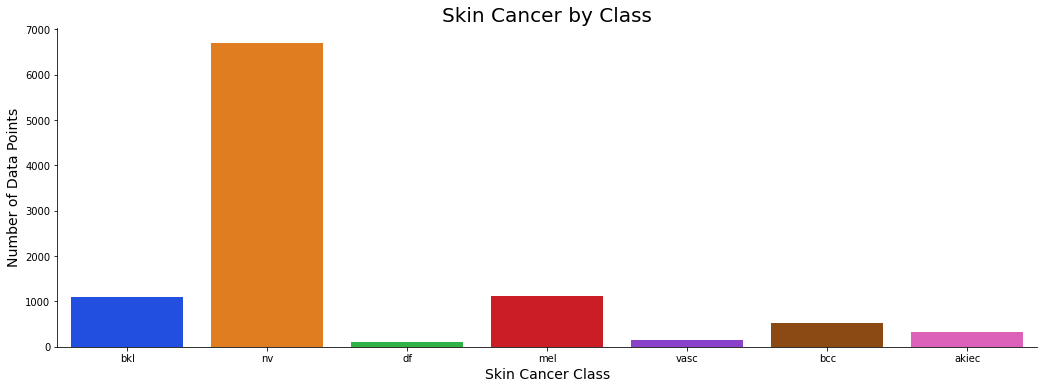

In [ ]:
g = sns.catplot(x="dx", kind="count", palette='bright', data=meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Class', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)

This graph shows the dataset has a major problem of class imbalance.

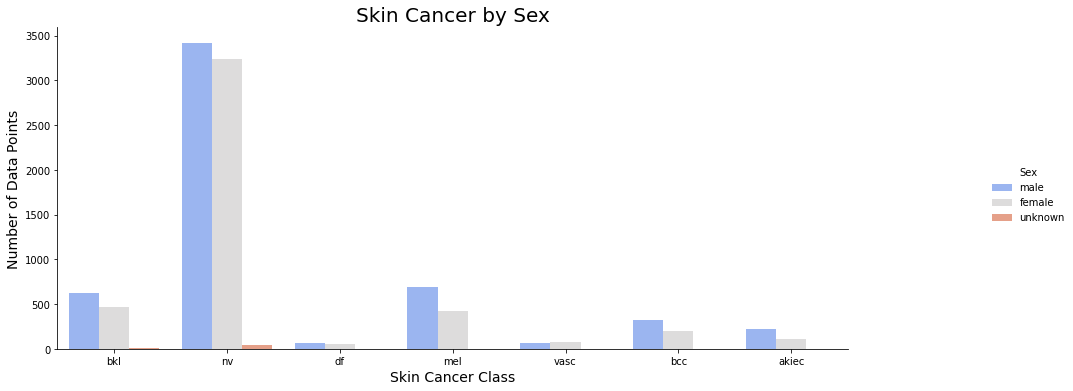

In [ ]:
g = sns.catplot(x="dx", kind="count", hue="sex", palette='coolwarm', data=meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Sex', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Sex')

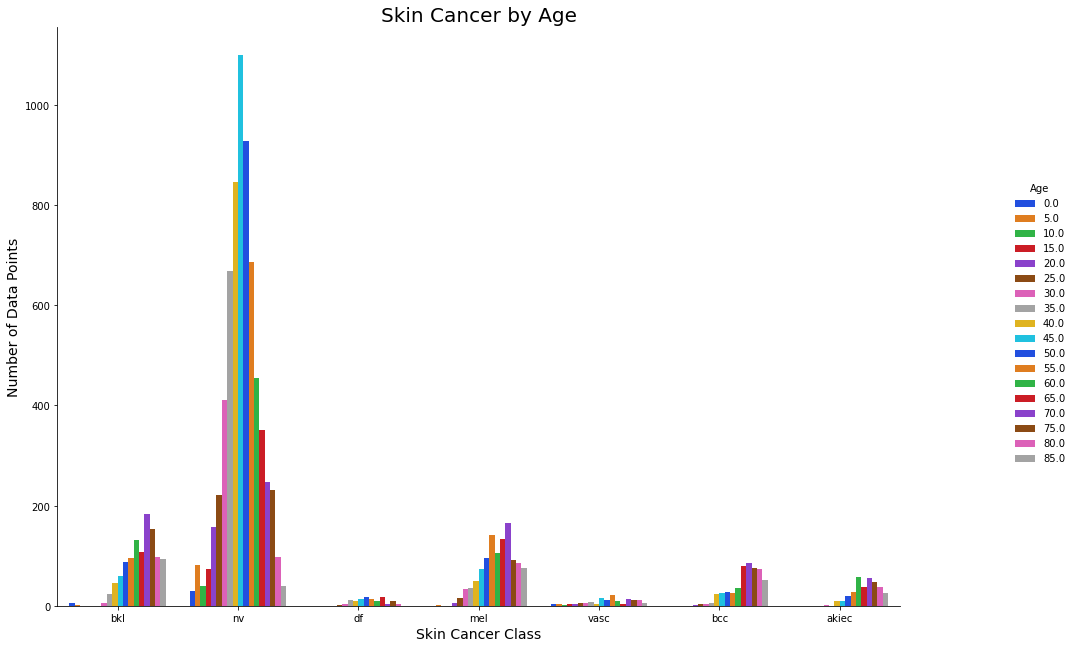

In [ ]:
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=meta)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')

# **Extracting x and y from csv file**

In [ ]:
df=pd.read_csv('/content/hmnist_28_28_RGB.csv')
x=df.drop('label',axis=1)
y=df['label']
x=x.to_numpy()
x=x/255
y=to_categorical(y)

In [ ]:
df['label'].value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [ ]:
label={
    ' Actinic keratoses':0,
    'Basal cell carcinoma':1,
    'Benign keratosis-like lesions':2,
    'Dermatofibroma':3,
    'Melanocytic nevi':4,
    'Melanoma':5,
    'Vascular lesions':6
}

In [ ]:
x=x.reshape(-1,28,28,3)

# **Spliiting into train test**

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.1,random_state=13,stratify=df['label'])

# **Image augmentation**

In [ ]:
datagen=ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

In [ ]:
datagen.fit(xtrain)

# **Model**

In [ ]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
def accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [ ]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop

model=Sequential()

model.add(Conv2D(64,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Conv2D(1024,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Conv2D(1024,(1,1),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(7,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[accuracy])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 512)       131584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 512)         2048      
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 512)         0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early=EarlyStopping(monitor='accuracy',patience=3)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=2, verbose=1, mode='min', min_lr=0.0001)

# **Training**

In [ ]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
def accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [ ]:
class_weights={0:1,1:1,2:1,3:1,4:0.5,5:1,6:1}

In [ ]:
model.fit(xtrain,ytrain,epochs=30,validation_data=(xtest,ytest),callbacks=[reduce_lr,early],class_weight=class_weights)

Epoch 1/30
282/282 [==============================] - 11s 12ms/step - loss: 1.2742 - accuracy: 0.7543 - val_loss: 2.6843 - val_accuracy: 0.1427
Epoch 2/30
282/282 [==============================] - 3s 10ms/step - loss: 0.7600 - accuracy: 0.8356 - val_loss: 1.1553 - val_accuracy: 0.7635
Epoch 3/30
282/282 [==============================] - 3s 10ms/step - loss: 0.7125 - accuracy: 0.8311 - val_loss: 0.9065 - val_accuracy: 0.8323

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/30
282/282 [==============================] - 3s 10ms/step - loss: 0.6508 - accuracy: 0.8564 - val_loss: 0.7187 - val_accuracy: 0.8812
Epoch 5/30
282/282 [==============================] - 3s 10ms/step - loss: 0.6161 - accuracy: 0.8791 - val_loss: 0.7303 - val_accuracy: 0.8663

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/30
282/282 [==============================] - 3s 10ms/step - loss: 0.5649 - accuracy: 0.8909 - val_loss: 0.7681 - 

# **Evaluation**


<Figure size 1080x720 with 0 Axes>

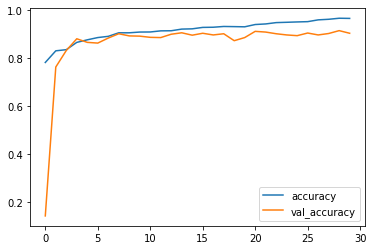

In [ ]:
p.figure(figsize=(15,10))
loss=pd.DataFrame(model.history.history)
loss[['accuracy','val_accuracy']].plot()

<Figure size 1080x720 with 0 Axes>

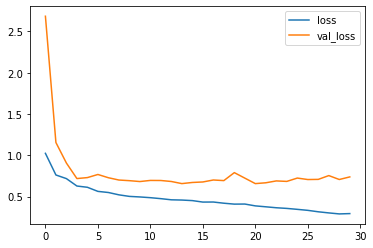

In [ ]:
p.figure(figsize=(15,10))
loss[['loss','val_loss']].plot()

In [ ]:
decode={
    0:'Actinic keratosis',
    1:'Basal cell carcinoma',
    2:'Benign keratosis-like lesions',
    3:'Dermatofibroma',
    4:'Melanocytic nevi',
    5:'Melanoma',
    6:'Vascular lesion'  
}

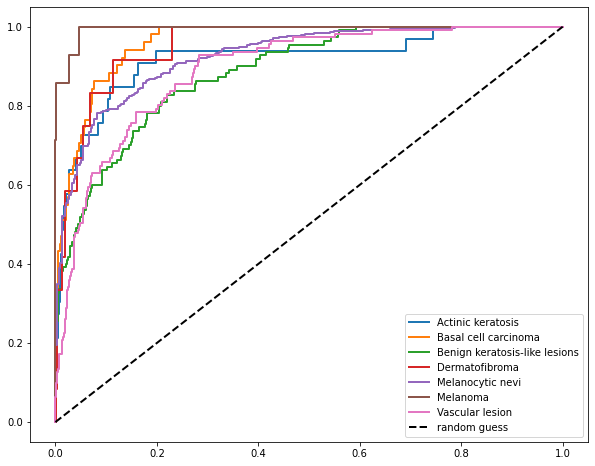

In [ ]:
p.figure(figsize=(10,8))

pred=model.predict(xtest)

from sklearn.metrics import roc_curve,auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(ytest[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(7):
    p.plot(fpr[i],tpr[i],label=decode[i],linewidth=2)
p.plot([0, 1], [0, 1], 'k--', lw=2,label='random guess')
p.legend(loc="lower right")

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

predictions=model.predict_classes(xtest)

check=[]
for i in range(len(ytest)):
  for j in range(7):
    if(ytest[i][j]==1):
      check.append(j)
check=np.asarray(check)
print(classification_report(check,predictions))

              precision    recall  f1-score   support

           0       0.61      0.33      0.43        33
           1       0.52      0.63      0.57        51
           2       0.42      0.64      0.50       110
           3       0.25      0.08      0.12        12
           4       0.90      0.86      0.88       671
           5       0.86      0.86      0.86        14
           6       0.57      0.52      0.55       111

    accuracy                           0.76      1002
   macro avg       0.59      0.56      0.56      1002
weighted avg       0.78      0.76      0.76      1002



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image
img = Image.open('/content/_275_7336136.jpg')
img = img.resize((28,28))
img = np.array(img)
img = img / 255.0
img = img.reshape(1,28,28,3)

preds = model.predict(img)
print(preds)
preds=np.around(preds, decimals = 3) 
max_value=max(preds[0])
print(max_value)
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
index(preds,max_value)

[[3.6675993e-02 8.9090866e-01 1.7153855e-02 1.1132138e-02 4.2071003e-02
  5.5267225e-04 1.5056912e-03]]
0.891


(0, 1)

In [ ]:

batch_holder = np.zeros((20, IMG_SIZE, IMG_SIZE, 3))
img_dir='/content/ham10000_images_part_2/'
for i,img in enumerate(os.listdir(img_dir)):
  img = image.load_img(os.path.join(img_dir,img), target_size=(IMG_SIZE,IMG_SIZE))
  batch_holder[i, :] = img

IndexError: ignored